# Setup

In [ ]:
!pip install --upgrade diffusers transformers huggingface-hub accelerate

In [ ]:
import sys
from diffusers import KandinskyV22Pipeline, KandinskyV22PriorPipeline
import torch
import PIL
import torch
from diffusers.utils import load_image
from torchvision import transforms
from transformers import CLIPVisionModelWithProjection
from diffusers.models import UNet2DConditionModel
import numpy as np
import os
import importlib.util
import huggingface_hub
from huggingface_hub import snapshot_download
from dataclasses import dataclass
from typing import Dict, List
import gc

# os.environ["HF_TOKEN"] = ""

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_grad_enabled(False)
torch.manual_seed(42)

@dataclass
class HF_CONFIG():
    _repo_id:str = "rexp10r/sae-for-kandinsky"
    _py_file_path:str = "model.py"
    _st_dict_path:str = "st_dict.pth"
    _class_name:str = "SAE"

    @property
    def repo_id(self):
      return self._repo_id

    @property
    def py_file_path(self):
      return self._py_file_path

    @property
    def st_dict_path(self):
      return self._st_dict_path

    @property
    def class_name(self):
      return self._class_name

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


# Definitions

In [ ]:
def create_model_loaders(hf_config, device):

    def clear_memory():
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    def load_kadinsky():
        image_encoder = CLIPVisionModelWithProjection.from_pretrained(
            'kandinsky-community/kandinsky-2-2-prior',
            subfolder='image_encoder'
        ).half().to(device)

        prior = KandinskyV22PriorPipeline.from_pretrained(
            'kandinsky-community/kandinsky-2-2-prior',
            image_encoder=image_encoder,
            torch_dtype=torch.float16
        ).to(device)

        unet = UNet2DConditionModel.from_pretrained(
            'kandinsky-community/kandinsky-2-2-decoder',
            subfolder='unet'
        ).half().to(device)

        decoder = KandinskyV22Pipeline.from_pretrained(
            'kandinsky-community/kandinsky-2-2-decoder',
            unet=unet,
            torch_dtype=torch.float16
        ).to(device)

        zero_embed = prior.get_zero_embed()
        clear_memory()

        return prior, decoder, zero_embed

    def load_sae():

        model_file_path = snapshot_download(repo_id=hf_config.repo_id)

        model_py_path = os.path.join(model_file_path, hf_config.py_file_path)
        weights_path = os.path.join(model_file_path, hf_config.st_dict_path)

        spec = importlib.util.spec_from_file_location("model_module", model_py_path)
        model_module = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(model_module)

        SparseAutoencoder = getattr(model_module, hf_config.class_name)
        model = SparseAutoencoder(1280, 128)

        state_dict = torch.load(weights_path, map_location=torch.device('cpu'))
        model.half()
        model.load_state_dict(state_dict)
        model.eval()
        model.to(device)
        clear_memory()

        return model
    return load_kadinsky, load_sae

In [ ]:
class InterpretableGenerator():
  def __init__(self, load_kandinsky, load_sae, device:str="cuda"):
    self._prior, self._decoder, self._zero_embed = load_kandinsky()
    self._sae = load_sae()
    self._device = device

    self._generator = torch.Generator(self._device).manual_seed(1)

  def _get_error(self, embed):
    recon, _ = self._sae(embed)
    error = embed - recon
    return error

  def _embed_image(self, item):
    return self._prior.interpolate([item], [1]).image_embeds[0]

  def _extract_sae_latent(self, item):
    embed = self._embed_image(item)
    latent = self._sae.encode(embed)
    return latent

  def generate_one(self, item, features_to_change:Dict[str, List]):
    embed = self._embed_image(item)
    features = self._sae.encode(embed)

    idxs = features_to_change["change_idxs"]
    coefs = features_to_change["change_coefs"]
    if len(idxs) == len(coefs):
      features[idxs] *= torch.tensor(coefs, device=self._device, dtype=torch.float32)

    input_embeds = self._sae.decode(features) + self._get_error(embed)
    del features, embed

    images = self._decoder(
      image_embeds=input_embeds.unsqueeze(0),
      negative_image_embeds=self._zero_embed,
      height=512,
      width=512,
      num_inference_steps=18,
      num_images_per_prompt=1,
      generator=self._generator,
    ).images

    return images[0]

  def _extract_top10(self, features):
    top_10 = features.argsort()[-10:]
    return reversed(top_10)

  def print_top_10(self, item):
    latent = self._extract_sae_latent(item)
    for idx in self._extract_top10(latent):
      print(f"Feature {idx:10d} = {latent[idx]:.2f}")


# Actions

In [ ]:
hf_config = HF_CONFIG()
load_kandinsky, load_sae = create_model_loaders(hf_config, DEVICE)
generator = InterpretableGenerator(load_kandinsky, load_sae, DEVICE)


## First sample

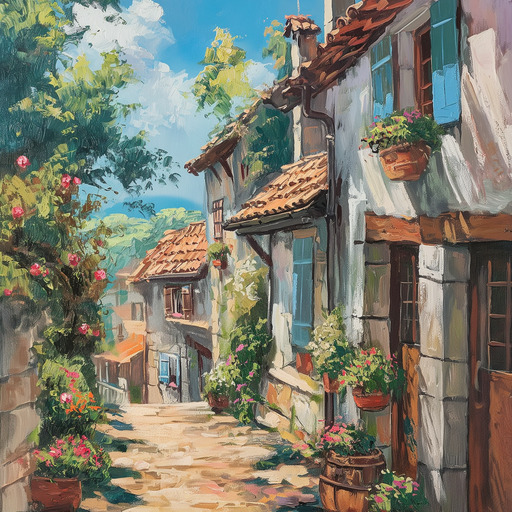

In [ ]:
img = load_image("https://images.featurelab.xyz/example_1.jpg")
img


In [ ]:
generator.print_top_10(img)

  0%|          | 0/25 [00:00<?, ?it/s]

Feature     131198 = 13.15
Feature     103372 = 9.74
Feature      10667 = 9.07
Feature     136354 = 8.79
Feature      77589 = 8.78
Feature     138800 = 8.30
Feature     149341 = 7.97
Feature       2556 = 7.84
Feature     162875 = 7.76
Feature      17622 = 7.52


**Got by experiments:**
- 131198 - south italian place
- 103372 - sweet blur in the distance
- 10667 - street with a man
- 136354 - light smooth

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

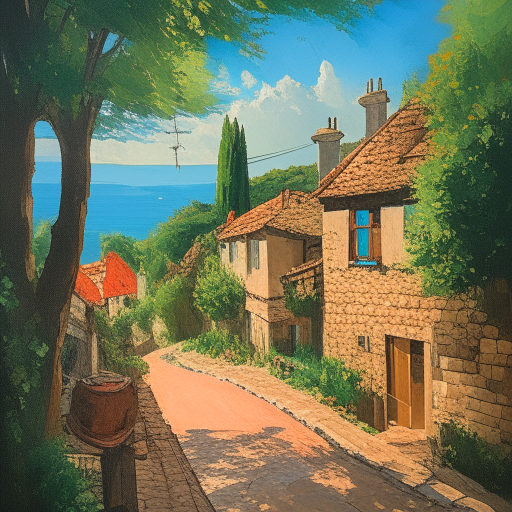

In [ ]:
change_conf = {
    "change_idxs": [131198],
    "change_coefs": [4]
}
generator.generate_one(img, change_conf)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

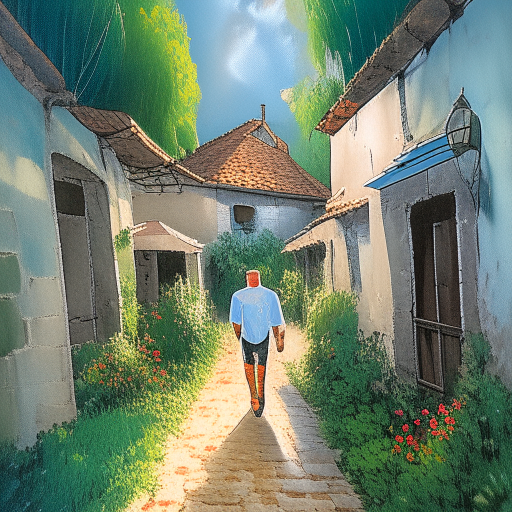

In [ ]:
change_conf = {
    "change_idxs": [103372, 10667, 136354],
    "change_coefs": [2, 8, 2]
}
generator.generate_one(img, change_conf)

## Second sample

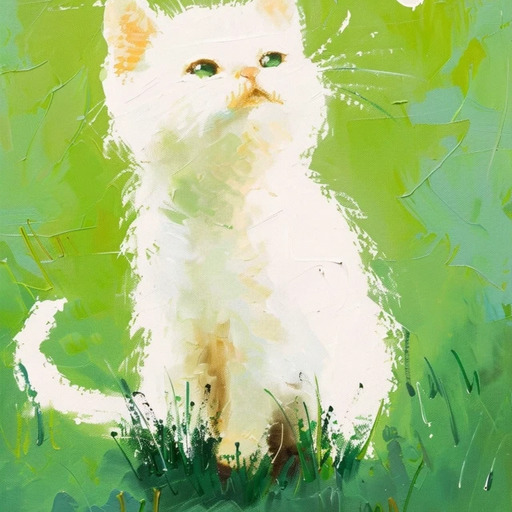

In [ ]:
img = load_image("https://images.featurelab.xyz/example_2.jpg")
img

Try to make it furry

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

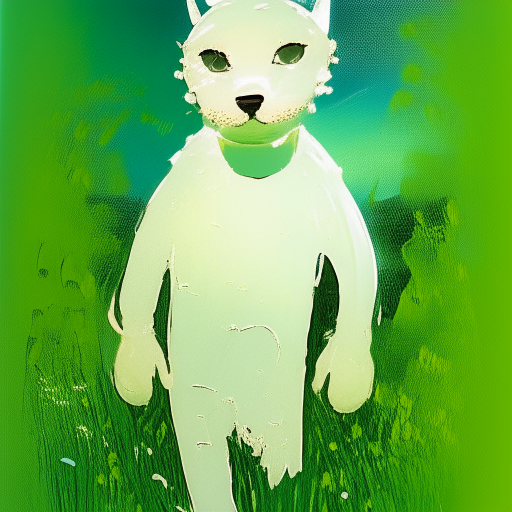

In [ ]:
# 10667 - humanization (street with a human above)

change_conf = {
    "change_idxs": [10667],
    "change_coefs": [12]
}
generator.generate_one(img, change_conf)

In [ ]:
generator.print_top_10(img)

  0%|          | 0/25 [00:00<?, ?it/s]

Feature       6051 = 11.33
Feature     149341 = 10.91
Feature     160831 = 10.51
Feature     148030 = 10.15
Feature      66832 = 8.56
Feature      77589 = 8.54
Feature     159602 = 8.24
Feature      21083 = 8.20
Feature       2556 = 7.98
Feature     143869 = 7.66


**Got by experiments:**
- 143869 - realistic style
- 2556 - buldings in the background
- 21083 - close up
- 159602 - minimalism

Remove the details

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

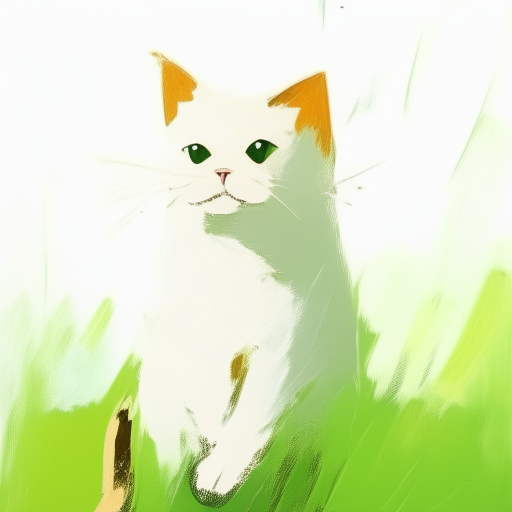

In [ ]:
change_conf = {
    "change_idxs": [159602],
    "change_coefs": [4]
}
generator.generate_one(img, change_conf)

Try to change the style to realistic one and add buildings

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

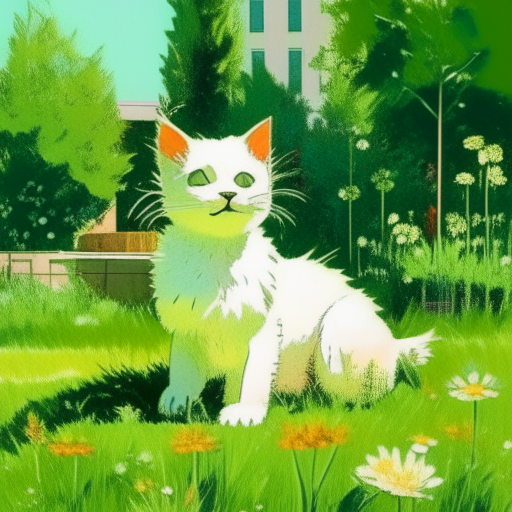

In [ ]:
change_conf = {
    "change_idxs": [143869, 2556],
    "change_coefs": [4, 8]
}
generator.generate_one(img, change_conf)

Let's make it closer

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

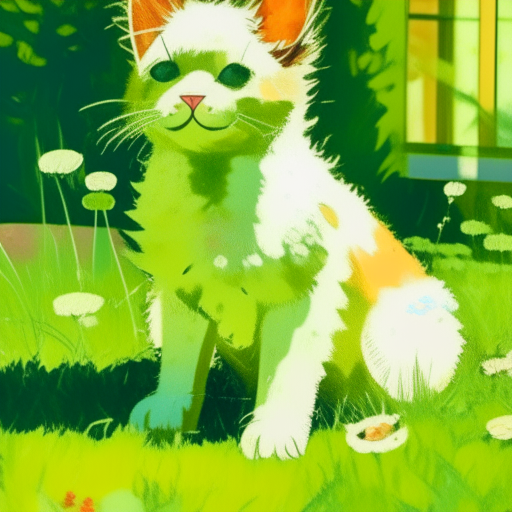

In [ ]:
change_conf = {
    "change_idxs": [143869, 2556, 21083],
    "change_coefs": [4, 8, 4]
}
generator.generate_one(img, change_conf)